/var/folders/pz/p1hrncws1n5gsmzgxczt0rpm0000gn/T/ipykernel_1659/704669669.py:51: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_train = df_train.groupby("Binary_Engagement", group_keys=False).apply(


Before balancing: Counter({1: 4651, 0: 231})
After balancing : Counter({0: 3720, 1: 3720})

===== RANDOM FOREST K-FOLD =====

---- Fold 1 ----
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       744
           1       1.00      0.98      0.99       744

    accuracy                           0.99      1488
   macro avg       0.99      0.99      0.99      1488
weighted avg       0.99      0.99      0.99      1488

[[744   0]
 [ 16 728]]

---- Fold 2 ----
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       744
           1       1.00      0.99      0.99       744

    accuracy                           0.99      1488
   macro avg       0.99      0.99      0.99      1488
weighted avg       0.99      0.99      0.99      1488

[[744   0]
 [ 10 734]]

---- Fold 3 ----
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       744
           1

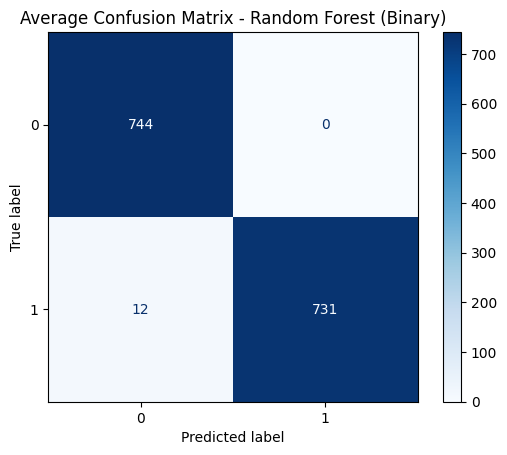


===== K-FOLD AVERAGE METRICS =====
Accuracy  : 0.992
Precision : 1.000
Recall    : 0.983
F1 Score  : 0.991

===== VALIDATION SET PERFORMANCE =====
              precision    recall  f1-score   support

           0       0.23      0.22      0.22        23
           1       0.96      0.96      0.96       465

    accuracy                           0.93       488
   macro avg       0.59      0.59      0.59       488
weighted avg       0.93      0.93      0.93       488

[[  5  18]
 [ 17 448]]


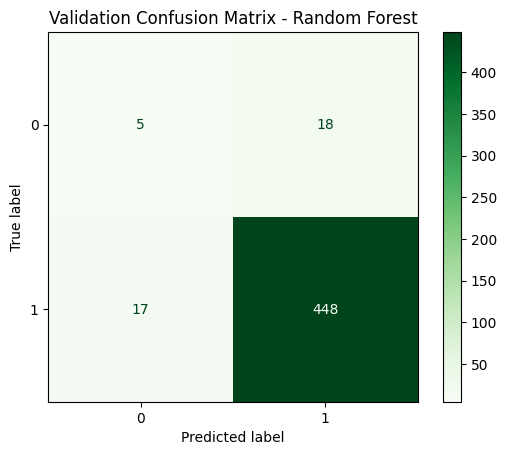

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt
from collections import Counter

# --- Load dataset ---
data = pd.read_csv("/Users/khushnumaparveen/Downloads/merged_results.csv")

# --- Select features ---
au_cols = [col for col in data.columns if col.startswith("au")]
landmark_cols = [col for col in data.columns if col.startswith("x_") or col.startswith("y_")]

possible_pose_cols = ["pose_Rx", "pose_Ry", "pose_Rz", "pitch", "yaw", "roll"]
pose_cols = [col for col in possible_pose_cols if col in data.columns]

feature_cols = au_cols + landmark_cols + pose_cols

# Features
X = data[feature_cols].fillna(0)

# -------------------------
# BINARY ENGAGEMENT LABEL
# -------------------------
data["Binary_Engagement"] = (data["Engagement"] >= 2).astype(int)
y = data["Binary_Engagement"]

# ------------------------------
# Train / Validation / Test Split (80 / 10 / 10)
# ------------------------------
X_train_full, X_temp, y_train_full, y_temp = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42
)

# ------------------------------
# Balance TRAIN SET ONLY
# ------------------------------
df_train = pd.concat([X_train_full, y_train_full], axis=1)
max_size = df_train["Binary_Engagement"].value_counts().max()

balanced_train = df_train.groupby("Binary_Engagement", group_keys=False).apply(
    lambda x: x.sample(max_size, replace=True, random_state=42)
).reset_index(drop=True)

X_bal = balanced_train[feature_cols]
y_bal = balanced_train["Binary_Engagement"]

print("Before balancing:", Counter(y))
print("After balancing :", Counter(y_bal))

# ------------------------------
# Scaling
# ------------------------------
scaler = StandardScaler()
X_bal_scaled = scaler.fit_transform(X_bal)
X_val_scaled = scaler.transform(X_val)

# ------------------------------
# STRATIFIED K-FOLD (5 folds)
# ------------------------------
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

accs, precs, recs, f1s = [], [], [], []
all_cm = np.zeros((2, 2), dtype=int)

print("\n===== RANDOM FOREST K-FOLD =====")

for fold, (train_idx, test_idx) in enumerate(skf.split(X_bal_scaled, y_bal), 1):
    X_train, X_test_fold = X_bal_scaled[train_idx], X_bal_scaled[test_idx]
    y_train, y_test_fold = y_bal.iloc[train_idx], y_bal.iloc[test_idx]

    model = RandomForestClassifier(
        n_estimators=300,
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=3,
        max_features='sqrt',
        class_weight='balanced',
        random_state=42
    )

    model.fit(X_train, y_train)
    pred = model.predict(X_test_fold)

    accs.append(accuracy_score(y_test_fold, pred))
    precs.append(precision_score(y_test_fold, pred, zero_division=0))
    recs.append(recall_score(y_test_fold, pred, zero_division=0))
    f1s.append(f1_score(y_test_fold, pred, zero_division=0))

    cm = confusion_matrix(y_test_fold, pred, labels=[0,1])
    all_cm += cm
    
    print(f"\n---- Fold {fold} ----")
    print(classification_report(y_test_fold, pred))
    print(cm)

# Average Confusion Matrix
avg_cm = all_cm // skf.get_n_splits()
print("\n===== AVERAGE CONFUSION MATRIX =====")
print(avg_cm)

disp = ConfusionMatrixDisplay(confusion_matrix=avg_cm, display_labels=[0,1])
disp.plot(cmap='Blues', values_format='d')
plt.title("Average Confusion Matrix - Random Forest (Binary)")
plt.show()

print("\n===== K-FOLD AVERAGE METRICS =====")
print(f"Accuracy  : {np.mean(accs):.3f}")
print(f"Precision : {np.mean(precs):.3f}")
print(f"Recall    : {np.mean(recs):.3f}")
print(f"F1 Score  : {np.mean(f1s):.3f}")

# ------------------------------
# Train FINAL model on full balanced train
# ------------------------------
final_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=3,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42
)
final_model.fit(X_bal_scaled, y_bal)

# ------------------------------
# VALIDATION PERFORMANCE
# ------------------------------
val_pred = final_model.predict(X_val_scaled)
print("\n===== VALIDATION SET PERFORMANCE =====")
print(classification_report(y_val, val_pred))

val_cm = confusion_matrix(y_val, val_pred)
print(val_cm)

disp = ConfusionMatrixDisplay(confusion_matrix=val_cm, display_labels=[0,1])
disp.plot(cmap='Greens', values_format='d')
plt.title("Validation Confusion Matrix - Random Forest")
plt.show()


In [25]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import f1_score
# from sklearn.model_selection import StratifiedKFold
# import numpy as np

# # ----------------------------
# # PARAMETER GRID (editable)
# # ----------------------------
# n_estimators_list = [200, 300, 500]
# max_depth_list = [10, 15, 20]
# min_samples_split_list = [2, 5, 10]
# min_samples_leaf_list = [1, 2, 3, 5]
# max_features_list = ["sqrt", "log2"]
# bootstrap_list = [True, False]

# # ----------------------------
# # TUNING LOOP
# # ----------------------------
# best_score = -1
# best_params = None

# skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# print("\n===== RANDOM FOREST Hyperparameter Tuning Started =====\n")

# for n_est in n_estimators_list:
#     for depth in max_depth_list:
#         for split in min_samples_split_list:
#             for leaf in min_samples_leaf_list:
#                 for feats in max_features_list:
#                     for boot in bootstrap_list:

#                         fold_scores = []

#                         for train_idx, val_idx in skf.split(X_bal_scaled, y_bal):
#                             X_tr, X_va = X_bal_scaled[train_idx], X_bal_scaled[val_idx]
#                             y_tr, y_va = y_bal.iloc[train_idx], y_bal.iloc[val_idx]

#                             model = RandomForestClassifier(
#                                 n_estimators=n_est,
#                                 max_depth=depth,
#                                 min_samples_split=split,
#                                 min_samples_leaf=leaf,
#                                 max_features=feats,
#                                 bootstrap=boot,
#                                 class_weight='balanced',
#                                 random_state=42,
#                                 n_jobs=-1
#                             )

#                             model.fit(X_tr, y_tr)
#                             preds = model.predict(X_va)

#                             score = f1_score(y_va, preds, zero_division=0)
#                             fold_scores.append(score)

#                         avg_score = np.mean(fold_scores)

#                         print(f"Params: n={n_est}, depth={depth}, split={split}, leaf={leaf}, "
#                               f"feat={feats}, boot={boot} --> F1={avg_score:.4f}")

#                         if avg_score > best_score:
#                             best_score = avg_score
#                             best_params = (n_est, depth, split, leaf, feats, boot)

# print("\n===== BEST RANDOM FOREST PARAMETERS FOUND =====")
# print("Best F1 Score:", best_score)
# print("Best Params:", best_params)



===== RANDOM FOREST Hyperparameter Tuning Started =====

Params: n=200, depth=10, split=2, leaf=1, feat=sqrt, boot=True --> F1=0.9773
Params: n=200, depth=10, split=2, leaf=1, feat=sqrt, boot=False --> F1=0.9776
Params: n=200, depth=10, split=2, leaf=1, feat=log2, boot=True --> F1=0.9756
Params: n=200, depth=10, split=2, leaf=1, feat=log2, boot=False --> F1=0.9795
Params: n=200, depth=10, split=2, leaf=2, feat=sqrt, boot=True --> F1=0.9754
Params: n=200, depth=10, split=2, leaf=2, feat=sqrt, boot=False --> F1=0.9786
Params: n=200, depth=10, split=2, leaf=2, feat=log2, boot=True --> F1=0.9772
Params: n=200, depth=10, split=2, leaf=2, feat=log2, boot=False --> F1=0.9762
Params: n=200, depth=10, split=2, leaf=3, feat=sqrt, boot=True --> F1=0.9766
Params: n=200, depth=10, split=2, leaf=3, feat=sqrt, boot=False --> F1=0.9777
Params: n=200, depth=10, split=2, leaf=3, feat=log2, boot=True --> F1=0.9744
Params: n=200, depth=10, split=2, leaf=3, feat=log2, boot=False --> F1=0.9776
Params: n=20

In [15]:

from sklearn.metrics import accuracy_score
test_accuracy = accuracy_score(y_test, test_pred)
print("\nTest Set Accuracy:", test_accuracy)

print("\n===== TEST SET PERFORMANCE =====")
print(classification_report(y_test, test_pred))

test_cm = confusion_matrix(y_test, test_pred)
print(test_cm)

disp = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=[0,1])
disp.plot(cmap="Blues", values_format='d')
plt.title("Random Forest - Test Confusion Matrix")
plt.show()

# Print accuracy separately
test_accuracy = accuracy_score(y_test, test_pred)
print("\nTest Set Accuracy:", round(test_accuracy, 4))


NameError: name 'test_pred' is not defined

/var/folders/pz/p1hrncws1n5gsmzgxczt0rpm0000gn/T/ipykernel_9510/299350358.py:51: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_train = df_train.groupby("Binary_Engagement", group_keys=False).apply(


Before balancing: Counter({1: 4651, 0: 231})
After balancing : Counter({0: 3720, 1: 3720})

===== RANDOM FOREST K-FOLD =====

---- Fold 1 ----
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       744
           1       1.00      0.99      0.99       744

    accuracy                           0.99      1488
   macro avg       0.99      0.99      0.99      1488
weighted avg       0.99      0.99      0.99      1488

[[744   0]
 [ 11 733]]

---- Fold 2 ----
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       744
           1       1.00      0.99      1.00       744

    accuracy                           1.00      1488
   macro avg       1.00      1.00      1.00      1488
weighted avg       1.00      1.00      1.00      1488

[[744   0]
 [  6 738]]

---- Fold 3 ----
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       744
           1

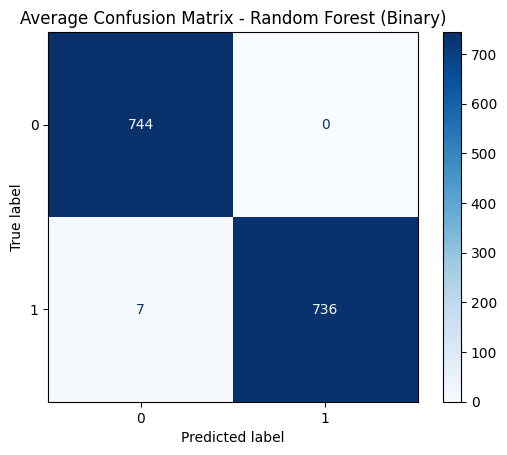


===== K-FOLD AVERAGE METRICS =====
Accuracy  : 0.995
Precision : 1.000
Recall    : 0.990
F1 Score  : 0.995

===== VALIDATION SET PERFORMANCE =====
              precision    recall  f1-score   support

           0       0.33      0.22      0.26        23
           1       0.96      0.98      0.97       465

    accuracy                           0.94       488
   macro avg       0.65      0.60      0.62       488
weighted avg       0.93      0.94      0.94       488

[[  5  18]
 [ 10 455]]


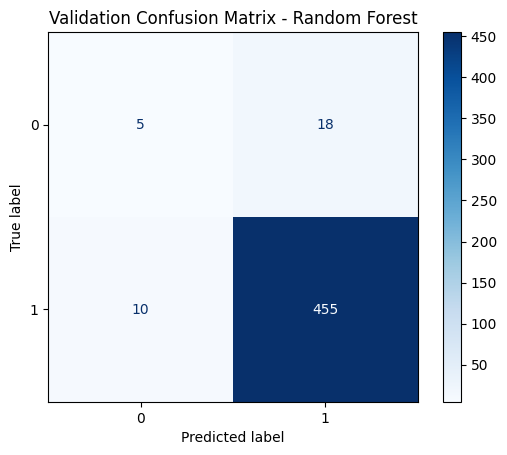

In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt
from collections import Counter

# --- Load dataset ---
data = pd.read_csv("/Users/khushnumaparveen/Downloads/merged_results.csv")

# --- Select features ---
au_cols = [col for col in data.columns if col.startswith("au")]
landmark_cols = [col for col in data.columns if col.startswith("x_") or col.startswith("y_")]

possible_pose_cols = ["pose_Rx", "pose_Ry", "pose_Rz", "pitch", "yaw", "roll"]
pose_cols = [col for col in possible_pose_cols if col in data.columns]

feature_cols = au_cols + landmark_cols + pose_cols

# Features
X = data[feature_cols].fillna(0)

# -------------------------
# BINARY ENGAGEMENT LABEL
# -------------------------
data["Binary_Engagement"] = (data["Engagement"] >= 2).astype(int)
y = data["Binary_Engagement"]

# ------------------------------
# Train / Validation / Test Split (80 / 10 / 10)
# ------------------------------
X_train_full, X_temp, y_train_full, y_temp = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42
)

# ------------------------------
# Balance TRAIN SET ONLY
# ------------------------------
df_train = pd.concat([X_train_full, y_train_full], axis=1)
max_size = df_train["Binary_Engagement"].value_counts().max()

balanced_train = df_train.groupby("Binary_Engagement", group_keys=False).apply(
    lambda x: x.sample(max_size, replace=True, random_state=42)
).reset_index(drop=True)

X_bal = balanced_train[feature_cols]
y_bal = balanced_train["Binary_Engagement"]

print("Before balancing:", Counter(y))
print("After balancing :", Counter(y_bal))

# ------------------------------
# Scaling
# ------------------------------
scaler = StandardScaler()
X_bal_scaled = scaler.fit_transform(X_bal)
X_val_scaled = scaler.transform(X_val)

# ------------------------------
# STRATIFIED K-FOLD (5 folds)
# ------------------------------
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

accs, precs, recs, f1s = [], [], [], []
all_cm = np.zeros((2, 2), dtype=int)

print("\n===== RANDOM FOREST K-FOLD =====")

for fold, (train_idx, test_idx) in enumerate(skf.split(X_bal_scaled, y_bal), 1):
    X_train, X_test_fold = X_bal_scaled[train_idx], X_bal_scaled[test_idx]
    y_train, y_test_fold = y_bal.iloc[train_idx], y_bal.iloc[test_idx]

    model = RandomForestClassifier(
        n_estimators=300,
        max_depth=20,
        min_samples_split=10,
        min_samples_leaf=1,
        max_features='sqrt',
        class_weight='balanced', #Best Params: (300, 20, 10, 1, 'sqrt', False)

        random_state=42
    )

    model.fit(X_train, y_train)
    pred = model.predict(X_test_fold)

    accs.append(accuracy_score(y_test_fold, pred))
    precs.append(precision_score(y_test_fold, pred, zero_division=0))
    recs.append(recall_score(y_test_fold, pred, zero_division=0))
    f1s.append(f1_score(y_test_fold, pred, zero_division=0))

    cm = confusion_matrix(y_test_fold, pred, labels=[0,1])
    all_cm += cm
    
    print(f"\n---- Fold {fold} ----")
    print(classification_report(y_test_fold, pred))
    print(cm)

# Average Confusion Matrix
avg_cm = all_cm // skf.get_n_splits()
print("\n===== AVERAGE CONFUSION MATRIX =====")
print(avg_cm)

disp = ConfusionMatrixDisplay(confusion_matrix=avg_cm, display_labels=[0,1])
disp.plot(cmap='Blues', values_format='d')
plt.title("Average Confusion Matrix - Random Forest (Binary)")
plt.show()

print("\n===== K-FOLD AVERAGE METRICS =====")
print(f"Accuracy  : {np.mean(accs):.3f}")
print(f"Precision : {np.mean(precs):.3f}")
print(f"Recall    : {np.mean(recs):.3f}")
print(f"F1 Score  : {np.mean(f1s):.3f}")

# ------------------------------
# Train FINAL model on full balanced train
# ------------------------------
final_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=1,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42
)
final_model.fit(X_bal_scaled, y_bal)

# ------------------------------
# VALIDATION PERFORMANCE
# ------------------------------
val_pred = final_model.predict(X_val_scaled)
print("\n===== VALIDATION SET PERFORMANCE =====")
print(classification_report(y_val, val_pred))

val_cm = confusion_matrix(y_val, val_pred)
print(val_cm)

disp = ConfusionMatrixDisplay(confusion_matrix=val_cm, display_labels=[0,1])
disp.plot(cmap='Blues', values_format='d')
plt.title("Validation Confusion Matrix - Random Forest")
plt.show()



===== TEST SET PERFORMANCE =====
Test Accuracy: 0.934560327198364
              precision    recall  f1-score   support

           0       0.26      0.22      0.24        23
           1       0.96      0.97      0.97       466

    accuracy                           0.93       489
   macro avg       0.61      0.59      0.60       489
weighted avg       0.93      0.93      0.93       489

[[  5  18]
 [ 14 452]]


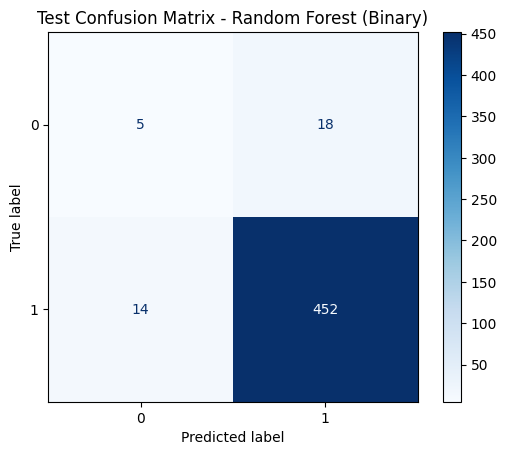

In [27]:
# ------------------------------
# SCALE THE TEST SET
# ------------------------------
X_test_scaled = scaler.transform(X_test)

# ------------------------------
# TEST SET PERFORMANCE
# ------------------------------
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

test_pred = final_model.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, test_pred)

print("\n===== TEST SET PERFORMANCE =====")
print("Test Accuracy:", test_accuracy)
print(classification_report(y_test, test_pred))

# Confusion Matrix
test_cm = confusion_matrix(y_test, test_pred)
print(test_cm)

# Plot
disp = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=[0, 1])
disp.plot(cmap="Blues", values_format='d')
plt.title("Test Confusion Matrix - Random Forest (Binary)")
plt.show()


In [21]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
)

def get_metrics_full(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)

    TN, FP = cm[0]
    FN, TP = cm[1]

    class0_accuracy = TN / (TN + FP) if (TN + FP) > 0 else 0
    class1_accuracy = TP / (TP + FN) if (TP + FN) > 0 else 0

    return {
        "Model": model_name,
        "Overall Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall": recall_score(y_true, y_pred, zero_division=0),
        "F1 Score": f1_score(y_true, y_pred, zero_division=0),
        "Class 0 Accuracy": class0_accuracy,
        "Class 1 Accuracy": class1_accuracy
    }


In [37]:
get_metrics_full(y_test,test_pred,"random Forest")

{'Model': 'random Forest',
 'Overall Accuracy': 0.9284253578732107,
 'Precision': 0.9654427645788337,
 'Recall': 0.9592274678111588,
 'F1 Score': 0.9623250807319699,
 'Class 0 Accuracy': 0.30434782608695654,
 'Class 1 Accuracy': 0.9592274678111588}

In [39]:
from sklearn.metrics import confusion_matrix

def accuracy_details(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    tn, fp, fn, tp = cm.ravel()

    acc_class_0 = tn / (tn + fn + 1e-9)
    acc_class_1 = tp / (tp + fp + 1e-9)
    overall_acc = (tp + tn) / (tp + tn + fp + fn)

    print("Confusion Matrix:\n", cm)
    print(f"\nAccuracy Class 0 (Disengaged): {acc_class_0:.3f}")
    print(f"Accuracy Class 1 (Engaged)   : {acc_class_1:.3f}")
    print(f"Overall Accuracy             : {overall_acc:.3f}")

accuracy_details(y_test,test_pred)

Confusion Matrix:
 [[  7  16]
 [ 19 447]]

Accuracy Class 0 (Disengaged): 0.269
Accuracy Class 1 (Engaged)   : 0.965
Overall Accuracy             : 0.928


In [33]:
print("\n===== DATA PREPROCESSING SUMMARY =====")

# 1. Original class distribution
print("\n▶ Original Class Distribution (Binary Engagement):")
print(Counter(y))

# 2. Train/Val/Test sizes
print("\n▶ Dataset Split Sizes (80/10/10):")
print("Train set size:", len(X_train_full))
print("Validation set size:", len(X_val))
print("Test set size:", len(X_test))

# 3. Balanced training class distribution
print("\n▶ Balanced Training Class Distribution:")
print(Counter(y_bal))

# 4. Feature counts
print("\n▶ Feature Summary:")
print("Total features used:", len(feature_cols))


# 5. Missing values check
print("\nMissing Value Check (after fillna):")
print(X.isna().sum().sum(), "missing values remaining")

# 6. Shapes after scaling
print("\n▶ Shape After Scaling:")
print("X_bal_scaled:", X_bal_scaled.shape)
print("X_val_scaled:", X_val_scaled.shape)

print("\n===== END OF PREPROCESSING REPORT =====\n")



===== DATA PREPROCESSING SUMMARY =====

▶ Original Class Distribution (Binary Engagement):
Counter({1: 4651, 0: 231})

▶ Dataset Split Sizes (80/10/10):
Train set size: 3905
Validation set size: 488
Test set size: 489

▶ Balanced Training Class Distribution:
Counter({0: 3720, 1: 3720})

▶ Feature Summary:
Total features used: 136

Missing Value Check (after fillna):
0 missing values remaining

▶ Shape After Scaling:
X_bal_scaled: (7440, 136)
X_val_scaled: (488, 136)

===== END OF PREPROCESSING REPORT =====

